In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('C:\\Users\\saleh\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages')

import os
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from xgboost import plot_importance
from math import ceil

C:\Users\saleh\AppData\Local\Temp\ipykernel_11892\9892940.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Define the folder path
folder_path = 'C:\\Users\\saleh\\Documents\\kaggle_sales_forecast\\data'

# Initialize a list to store dataframes
dataframes = []

# Optionally, if you want to store dataframes in a dictionary with filenames as keys
dataframes_dict = {os.path.splitext(filename)[0]: pd.read_csv(os.path.join(folder_path, filename)) for filename in os.listdir(folder_path) if filename.endswith(('.csv', '.xls'))}


In [3]:
dataframes_dict.keys()

dict_keys(['holidays_events', 'oil', 'sample_submission', 'stores', 'test', 'train', 'transactions'])

In [4]:
train = dataframes_dict['train']
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
train.describe()

,id,store_nbr,sales,onpromotion
count,3000888.00,3000888.00,3000888.00,3000888.00
mean,1500443.50,27.50,357.78,2.60
std,866281.89,15.59,1102.00,12.22
min,0.00,1.00,0.00,0.00
25%,750221.75,14.00,0.00,0.00
50%,1500443.50,27.50,11.00,0.00
75%,2250665.25,41.00,195.85,0.00
max,3000887.00,54.00,124717.00,741.00


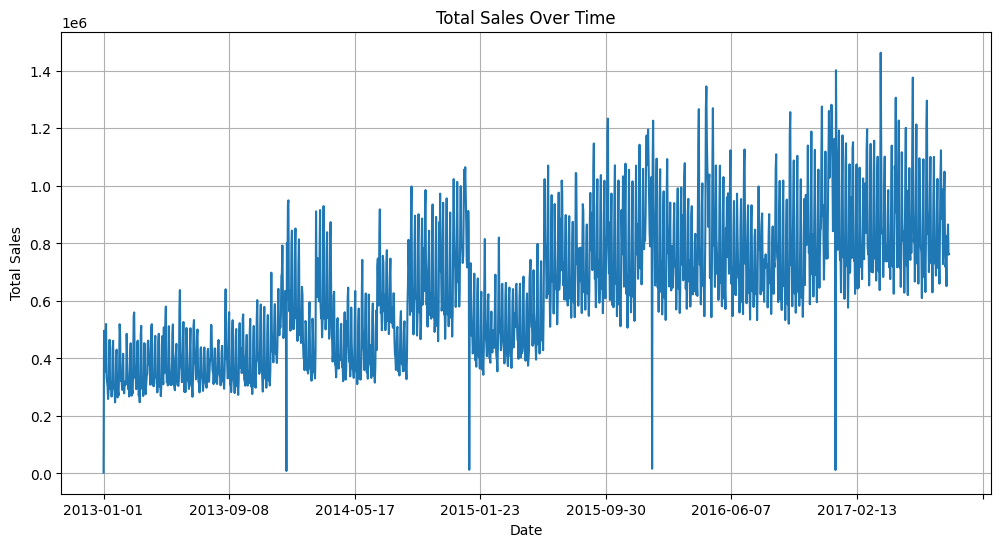

In [6]:
# Plot total sales over time
train.groupby('date')['sales'].sum().plot(kind='line', figsize=(12, 6))
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

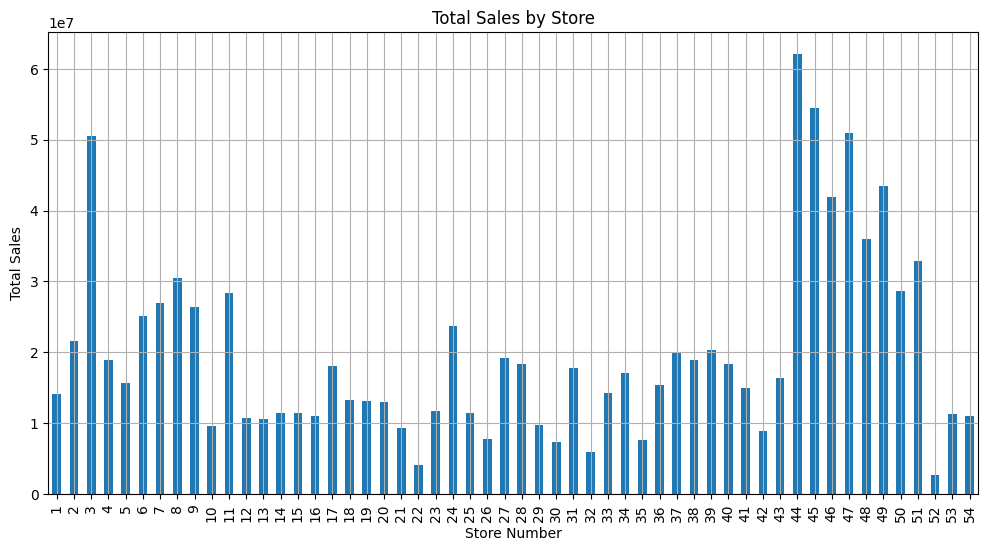

In [7]:
# Plot sales by store
train.groupby('store_nbr')['sales'].sum().plot(kind='bar', figsize=(12, 6))
plt.title('Total Sales by Store')
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

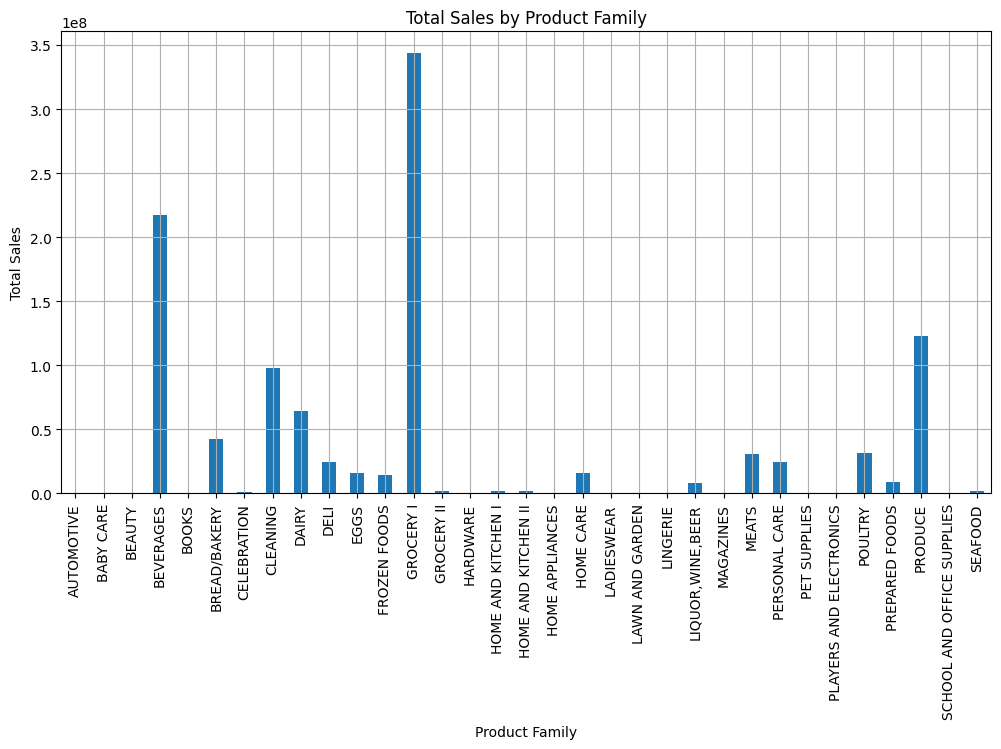

In [8]:
# Plot sales by product family
train.groupby('family')['sales'].sum().plot(kind='bar', figsize=(12, 6))
plt.title('Total Sales by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

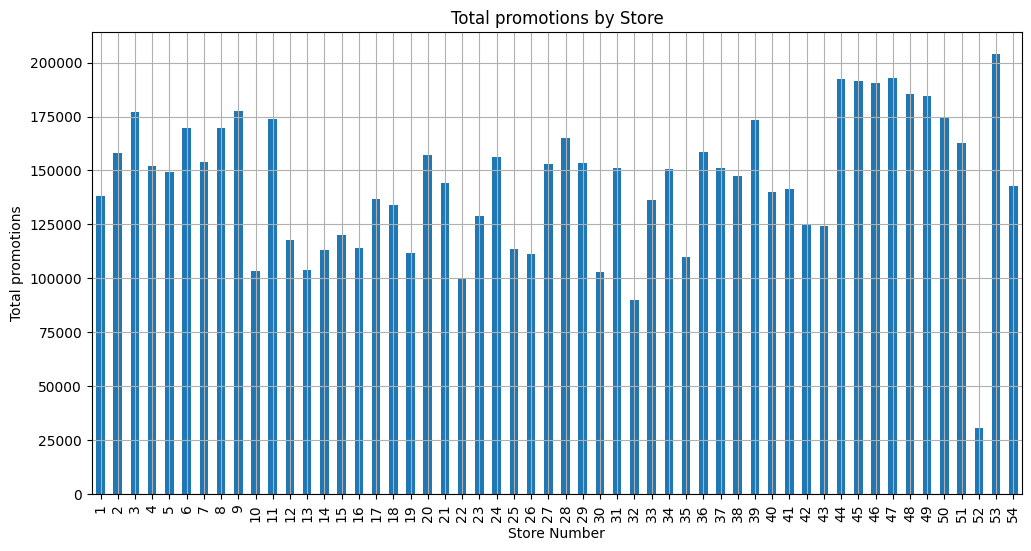

In [9]:
# Plot promotions by store
train.groupby('store_nbr')['onpromotion'].sum().plot(kind='bar', figsize=(12, 6))
plt.title('Total promotions by Store')
plt.xlabel('Store Number')
plt.ylabel('Total promotions')
plt.grid(True)
plt.show()

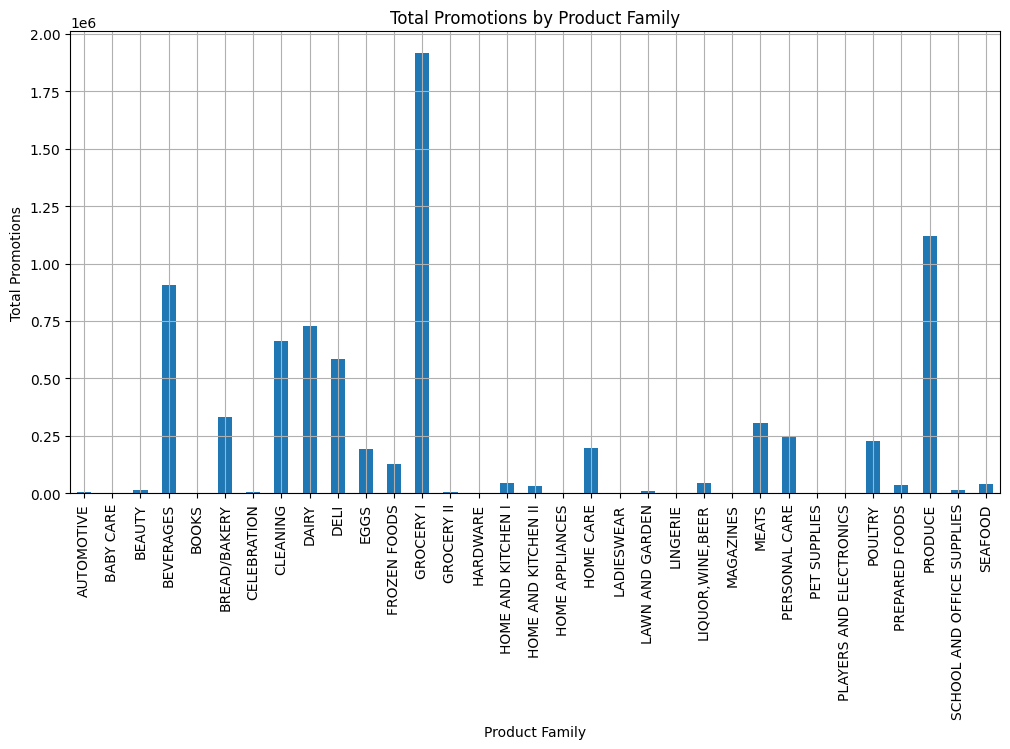

In [10]:
# Plot promotions by product family
train.groupby('family')['onpromotion'].sum().plot(kind='bar', figsize=(12, 6))
plt.title('Total Promotions by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Total Promotions')
plt.grid(True)
plt.show()

In [11]:
transactions = dataframes_dict['transactions']
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


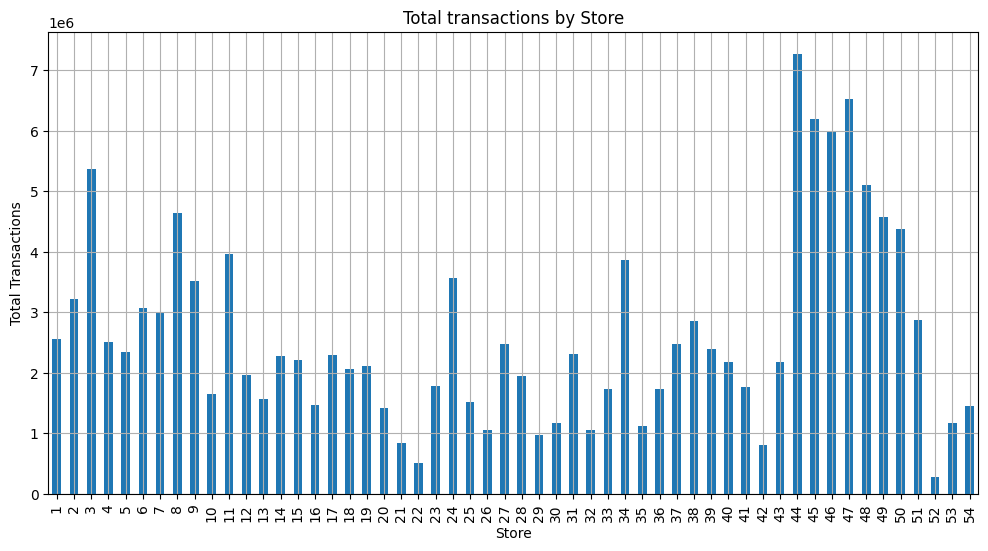

In [12]:
# Plot transactions by store
transactions.groupby('store_nbr')['transactions'].sum().plot(kind='bar', figsize=(12, 6))
plt.title('Total transactions by Store')
plt.xlabel('Store')
plt.ylabel('Total Transactions')
plt.grid(True)
plt.show()

In [13]:
stores = dataframes_dict['stores']
#stores

In [14]:
holidays_events = dataframes_dict['holidays_events']
#holidays_events.loc[(holidays_events['locale'] == 'National'),]

In [15]:
train['date'] = pd.to_datetime(train['date'])
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


In [16]:
def create_date_features(df):
    
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    

    def week_of_month(dt):
        """ Returns the week of the month for the specified date.
        """

        first_day = dt.replace(day=1)

        dom = dt.day
        adjusted_dom = dom + first_day.weekday()

        return int(ceil(adjusted_dom/7.0))
    
    df['weekofmonth'] = df['date'].apply(week_of_month)
    
    return df

In [17]:
train = pd.merge(left=train, right=stores, how='left', on='store_nbr')
#train

In [18]:
test = dataframes_dict['test']
test['date'] = pd.to_datetime(test['date'])
test = pd.merge(left=test, right=stores, how='left', on='store_nbr')
#test

In [19]:
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
holidays_events = holidays_events.rename(columns={
    'type': 'holiday_type',
    'description': 'holiday_description'
})
national_holidays = holidays_events[holidays_events.locale == 'National']
regional_holidays = holidays_events[holidays_events.locale == 'Regional']
local_holidays = holidays_events[holidays_events.locale == 'Local']
#local_holidays

In [20]:
train = pd.merge(left=train, right=national_holidays, how='left', on='date')
test = pd.merge(left=test, right=national_holidays, how='left', on='date')

In [38]:
# Merge df1 and df2 based on 'col1' and 'col2'
merged_train = pd.merge(train, regional_holidays, left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left', suffixes=('', '_update'))

# Update df1 with the values from df2 wherever df2 is joined
for col in regional_holidays.columns:
    if col not in ['date', 'locale_name']:  # Exclude the join columns
        merged_train[col] = merged_train[col + '_update'].combine_first(merged_train[col])

# Drop the extra columns used for updating
merged_train = merged_train[train.columns]

merged_test = pd.merge(test, regional_holidays, left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left', suffixes=('', '_update'))

# Update df1 with the values from df2 wherever df2 is joined
for col in regional_holidays.columns:
    if col not in ['date', 'locale_name']:  # Exclude the join columns
        merged_test[col] = merged_test[col + '_update'].combine_first(merged_test[col])

# Drop the extra columns used for updating
merged_test = merged_test[test.columns]
#merged_test

In [39]:
merged_train = merged_train.drop('locale_name', axis=1)
merged_test = merged_test.drop('locale_name', axis=1)

In [40]:
merged_test.columns[merged_test.isna().any()]

Index(['holiday_type', 'locale', 'holiday_description', 'transferred'], dtype='object')

In [41]:
merged_train.fillna('NA', inplace=True)
merged_test.fillna('NA', inplace=True)

In [42]:

merged_train['cluster'] = merged_train['cluster'].astype(object)
merged_test['cluster'] = merged_test['cluster'].astype(object)


In [43]:
def create_lag_features(df, group_cols, target_col, lags=[1, 7, 30]):
    """
    Create lag features and rolling statistics for the target column within each group.

    Parameters:
    - df: pandas DataFrame containing the data
    - group_cols: list of column names representing the groups (e.g., ['store', 'family'])
    - target_col: column name representing the target variable (e.g., 'sales')
    - lags: list of integers representing lag periods (e.g., [1, 7, 30])

    Returns:
    - df: pandas DataFrame with the newly created lag and rolling features
    """
    # Ensure the data is sorted by the group columns and date
    df = df.sort_values(by=group_cols + ['date'])
    
    # Create lag features
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df.groupby(group_cols)[target_col].shift(lag)

    return df


In [36]:
#merged_train.groupby(['family','store_nbr'])[lag_cols].rolling(2).mean().reset_index(drop=True)
#merged_train.groupby(group_cols)[lag_cols].shift(1)

In [44]:
lag_cols = 'sales'
group_cols = ['family','store_nbr']
lags = [1,2,7,15,30]
#rolling_windows = [2]

merged_train = create_lag_features(merged_train,group_cols,lag_cols,lags)
#test_data = create_lag_features(test_data,'date',lag_cols,lags)

In [47]:
merged_train.set_index('id').sort_values(by='id').tail()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,holiday_type,locale,holiday_description,transferred,sales_lag_1,sales_lag_2,sales_lag_7,sales_lag_15,sales_lag_30
id,,,,,,,,,,,,,,,,,,
3000883,2017-08-15,9,POULTRY,438.13,0,Quito,Pichincha,B,6,NA,NA,NA,NA,283.43,412.46,358.13,470.51,571.33
3000884,2017-08-15,9,PREPARED FOODS,154.55,1,Quito,Pichincha,B,6,NA,NA,NA,NA,114.12,105.17,112.95,61.94,125.96
3000885,2017-08-15,9,PRODUCE,2419.73,148,Quito,Pichincha,B,6,NA,NA,NA,NA,1348.42,1693.61,2299.72,1517.55,2041.97
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.00,8,Quito,Pichincha,B,6,NA,NA,NA,NA,182.00,200.00,170.00,56.00,0.00
3000887,2017-08-15,9,SEAFOOD,16.00,0,Quito,Pichincha,B,6,NA,NA,NA,NA,17.00,20.00,15.68,12.00,18.33


# continue from here

In [27]:
def one_hot_encoding(train,test,cat_features):
    ohe = OneHotEncoder()
    
    ohe_train = ohe.fit_transform(train[cat_features]).toarray()
    ohe_train = pd.DataFrame(ohe_train,columns=ohe.get_feature_names_out())
    train.drop(cat_features,axis=1,inplace=True)
    train.reset_index(drop=True,inplace=True)
    train = pd.concat([train,ohe_train],axis=1)
    
    ohe_test = ohe.transform(test[cat_features]).toarray()
    ohe_test = pd.DataFrame(ohe_test,columns=ohe.get_feature_names_out())
    test.drop(cat_features,axis=1,inplace=True)
    test.reset_index(drop=True,inplace=True)
    test = pd.concat([test,ohe_test],axis=1)
    
    return (train,test)

In [28]:
merged_train[cat_features] = merged_train[cat_features].astype(str)
merged_test[cat_features] = merged_test[cat_features].astype(str)

In [38]:
# merged_train.tail(20)
# merged_train.loc[(merged_train['holiday_type'] != 'NA'),]
# merged_train.groupby(['holiday_type','holiday_description']).size().reset_index(name='counts')

merged_train = merged_train.drop(columns=['holiday_description'])
merged_test = merged_test.drop(columns=['holiday_description'])
cat_features = merged_train.columns[merged_train.dtypes=='object']

In [39]:
train_data,test_data = one_hot_encoding(merged_train,merged_test,cat_features)

In [42]:
#train_data.shape

In [43]:
train_data = create_date_features(train_data)
test_data = create_date_features(test_data)

In [44]:
train_data.tail()

,id,date,store_nbr,sales,onpromotion,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,...,locale_National,locale_Regional,transferred_False,transferred_NA,transferred_True,quarter,month,year,weekofyear,weekofmonth
3008011,3000883,2017-08-15,9,438.13,0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,3,8,2017,33,3
3008012,3000884,2017-08-15,9,154.55,1,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,3,8,2017,33,3
3008013,3000885,2017-08-15,9,2419.73,148,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,3,8,2017,33,3
3008014,3000886,2017-08-15,9,121.00,8,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,3,8,2017,33,3
3008015,3000887,2017-08-15,9,16.00,0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,3,8,2017,33,3


In [45]:

# def create_lag_features(df, date_col, lag_cols, lags):
#     """
#     Create lag features for a dataset based on a date column.

#     Parameters:
#     - df (pd.DataFrame): The input dataset.
#     - date_col (str): The name of the date column.
#     - lag_cols (list of str): List of column names for which to create lag features.
#     - lags (list of int): List of lags to create (e.g., [1, 2, 3] for 1-day, 2-day, 3-day lags).

#     Returns:
#     - pd.DataFrame: The original dataframe with added lag features.
#     """
#     # Ensure the date column is in datetime format
#     df[date_col] = pd.to_datetime(df[date_col])

#     # Sort the dataframe by date
#     df = df.sort_values(by=date_col)

#     # Create lag features
#     for col in lag_cols:
#         for lag in lags:
#             df[f'{col}_lag_{lag}'] = df[col].shift(lag)

#     return df


In [47]:
train_data.tail()

,id,date,store_nbr,sales,onpromotion,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,...,quarter,month,year,weekofyear,weekofmonth,sales_lag_1,sales_lag_2,sales_lag_7,sales_lag_15,sales_lag_30
3006821,2999693,2017-08-15,25,3.00,0,0.00,0.00,0.00,0.00,0.00,...,3,8,2017,33,3,3.00,172.52,3.00,263.00,7.00
3006820,2999692,2017-08-15,25,93.00,8,0.00,0.00,0.00,0.00,0.00,...,3,8,2017,33,3,3.00,3.00,4.00,284.00,35.91
3006819,2999691,2017-08-15,25,180.11,0,0.00,0.00,0.00,0.00,0.00,...,3,8,2017,33,3,93.00,3.00,1.00,4.00,0.00
3006830,2999702,2017-08-15,26,0.00,0,0.00,0.00,1.00,0.00,0.00,...,3,8,2017,33,3,180.11,93.00,1269.17,215.00,3651.33
3008015,3000887,2017-08-15,9,16.00,0,0.00,0.00,0.00,0.00,0.00,...,3,8,2017,33,3,0.00,180.11,25.47,0.00,103.04


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Custom metric function
def custom_metric(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    log_diff = np.log(1 + y_pred) - np.log(1 + y_true)
    squared_diff = np.square(log_diff)
    mean_squared_diff = np.mean(squared_diff)
    return np.sqrt(mean_squared_diff)


In [52]:
train_data.columns[train_data.isna().any()]

Index(['sales_lag_1', 'sales_lag_2', 'sales_lag_7', 'sales_lag_15',
       'sales_lag_30'],
      dtype='object')

In [53]:
train_data.fillna(0, inplace=True)

In [55]:
# Ensure data is sorted by date
train_data = train_data.sort_values(by='date')
train_data = train_data.drop(columns=['date'])

# Define features and target
X = train_data.drop(columns=['sales'])
y = train_data['sales']

# Train-test split based on temporal order
split_index = int(len(train_data) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [56]:

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model using the custom metric
custom_metric_value = custom_metric(y_test, y_pred)
print(f'Custom Metric: {custom_metric_value}')

# You can still check other metrics if needed
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


Custom Metric: nan
Mean Squared Error: 724360.3230945922
Mean Absolute Error: 334.4589169285301


C:\Users\saleh\AppData\Local\Temp\ipykernel_15664\1978006300.py:9: RuntimeWarning: invalid value encountered in log
  log_diff = np.log(1 + y_pred) - np.log(1 + y_true)


# Results using overall lag features, not specific to store or product family
Custom Metric: nan
Mean Squared Error: 724360.3230945922
Mean Absolute Error: 334.4589169285301

In [42]:
X_train.dtypes

id                     int64
store_nbr              int64
onpromotion            int64
family_AUTOMOTIVE    float64
family_BABY CARE     float64
                      ...   
sales_lag_1          float64
sales_lag_2          float64
sales_lag_7          float64
sales_lag_15         float64
sales_lag_30         float64
Length: 195, dtype: object

In [40]:
merged_train.tail()

,id,date,store_nbr,sales,onpromotion
3008011,3000883,2017-08-15,9,438.13,0
3008012,3000884,2017-08-15,9,154.55,1
3008013,3000885,2017-08-15,9,2419.73,148
3008014,3000886,2017-08-15,9,121.00,8
3008015,3000887,2017-08-15,9,16.00,0


In [57]:
merged_test

,id,date,store_nbr,onpromotion
0,3000888,2017-08-16,1,0
1,3000889,2017-08-16,1,0
2,3000890,2017-08-16,1,2
3,3000891,2017-08-16,1,20
4,3000892,2017-08-16,1,0
...,...,...,...,...
28507,3029395,2017-08-31,9,1
28508,3029396,2017-08-31,9,0
28509,3029397,2017-08-31,9,1
28510,3029398,2017-08-31,9,9
